#  Y = 2 vs all

# checkpoint 1

In [75]:
YEQUALS = 2

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import log
import warnings
warnings.filterwarnings("ignore")
# install libraries
from sklearn.model_selection import train_test_split
import os
! pwd
import sys
sys.path.append('../Library')

from data_prep import PreProcessor1

import library_leo as leo



/Users/leonardodicaterina/Documents/GitHub/Machine_Learning_G19/Notebooks


In [77]:
train_path = "../Data/train_data.csv"
test_path = "../Data/test_data.csv"
# Replace 'Column29' with the actual column name that has mixed types
dtype = {'Column29': 'str'}

train = pd.read_csv(train_path, dtype=dtype,index_col='Claim Identifier')
dtest = pd.read_csv(test_path, dtype=dtype,index_col='Claim Identifier')

In [78]:
train = train.dropna(subset=['Claim Injury Type'])
y = train['Claim Injury Type']
train = train.drop(columns=['Claim Injury Type'])
y_str = y.str[:1]
y_int = y_str.astype(int)
# make Y_int 1 if it's equal to YEQUALS else 0
y_int = y_int.apply(lambda x: 1 if x == YEQUALS else 0)

In [79]:
# partition the data X, y and y_2bin
X_train, X_valid, y_train,y_valid = train_test_split(
    train, y_int, test_size=0.2, random_state=0)

In [80]:
y_train.value_counts()

Claim Injury Type
1    233101
0    226119
Name: count, dtype: int64

In [81]:
pr = PreProcessor1()
print("------------updates---------------------")
pr.update_casted_cols()
print("------------set_casting---------------------")
pr.set_castings(X_train)
print("------------pipeline---------------------")
df_train = pr.cast_pipeline(X_train)
print("df after cast_pipeline:", df_train.shape)
print("------------fillna---------------------")
pr.update_fillna_list(df_train)   
df_train = pr.fillna_pipeline(df_train)
print("df after fillna_pipeline:", df_train.shape)
print("------------transformation---------------------")
pr.set_transformations(df_train)
pr.append_transformation('Carrier Name','freq_encode','fe_Carrier Name')
df_train = pr.transformation_pipeline(df_train)
print("df after transformation_pipeline:", df_train.shape)
df_train= pr.scaling_pipeline(df_train)
df_train = df_train.drop(columns=['Agreement Reached', 'WCB Decision'])
df_train.info() 

------------updates---------------------
------------set_casting---------------------
Columns that are not casted:
-WCB Decision: object
------------pipeline---------------------
Feature Carrier Type is already in scaling list
Feature Zip Code is already in scaling list
'Industry Code Description'
-Column Industry Code Description not found
df after cast_pipeline: (459220, 26)
------------fillna---------------------
extended fillna_list: [('Age at Injury', 'median'), ('Average Weekly Wage', 'median'), ('Birth Year', 'median'), ('IME-4 Count', 'median'), ('Industry Code', 'median'), ('WCIO Cause of Injury Code', 'median'), ('WCIO Nature of Injury Code', 'median'), ('WCIO Part Of Body Code', 'median'), ('Zip Code', 'median'), ('Agreement Reached', 'median'), ('Number of Dependents', 'median'), ('Accident Date', 'mode'), ('Alternative Dispute Resolution', 'mode'), ('Assembly Date', 'mode'), ('Attorney/Representative', 'mode'), ('C-2 Date', 'mode'), ('C-3 Date', 'mode'), ('Carrier Name', '

In [82]:
pr.update_status('valid')
print("------------updates---------------------")
pr.update_casted_cols()
print("------------set_casting---------------------")
pr.set_castings(X_valid)
print("------------pipeline---------------------")
df_valid = pr.cast_pipeline(X_valid)
print("df after cast_pipeline:", df_valid.shape)
print("------------fillna---------------------")
pr.update_fillna_list(df_valid)   
df_valid = pr.fillna_pipeline(df_valid)
print("df after fillna_pipeline:", df_valid.shape)
print("------------transformation---------------------")
pr.set_transformations(df_valid)
df_valid = pr.transformation_pipeline(df_valid)
print("df after transformation_pipeline:", df_valid.shape)
df_valid = pr.scaling_pipeline(df_valid)
df_valid = df_valid.drop(columns=['Agreement Reached', 'WCB Decision'])

df_valid.info()

------------updates---------------------
------------set_casting---------------------
Columns that are not casted:
-WCB Decision: object
------------pipeline---------------------
Feature Carrier Type is already in scaling list
Feature Zip Code is already in scaling list
'Industry Code Description'
-Column Industry Code Description not found
"['Industry Code Description'] not found in axis"
-Column Industry Code Description not found
"['OIICS Nature of Injury Description'] not found in axis"
-Column OIICS Nature of Injury Description not found
"['WCIO Cause of Injury Description'] not found in axis"
-Column WCIO Cause of Injury Description not found
"['WCIO Nature of Injury Description'] not found in axis"
-Column WCIO Nature of Injury Description not found
"['WCIO Part Of Body Description'] not found in axis"
-Column WCIO Part Of Body Description not found
'Industry Code Description'
-Column Industry Code Description not found
df after cast_pipeline: (114806, 26)
------------fillna----

## feature selection

In [83]:
num_features = df_train.select_dtypes(include=[np.number]).columns
obj_features = df_train.select_dtypes(include=[object,'string']).columns


In [84]:
obj_features

Index(['Carrier Name', 'Carrier Type', 'County of Injury', 'District Name',
       'Gender', 'Medical Fee Region'],
      dtype='object')

### correlation with target

#### Linear correlation


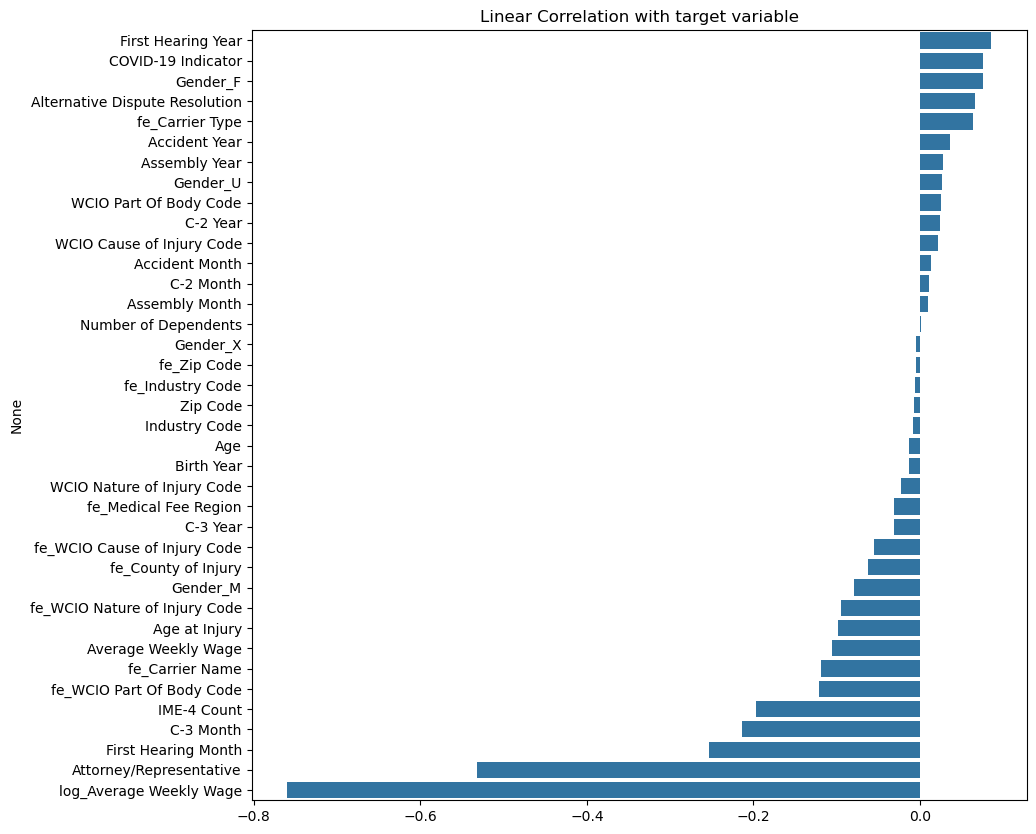

In [85]:
corr_y = df_train[num_features].corrwith(y_train)
corr_y = corr_y.sort_values(ascending=False)

plt.figure(figsize=(10, 10))
sns.barplot(x=corr_y.values, y=corr_y.index)
plt.title('Linear Correlation with target variable')

plt.show()

#### entropy correlation

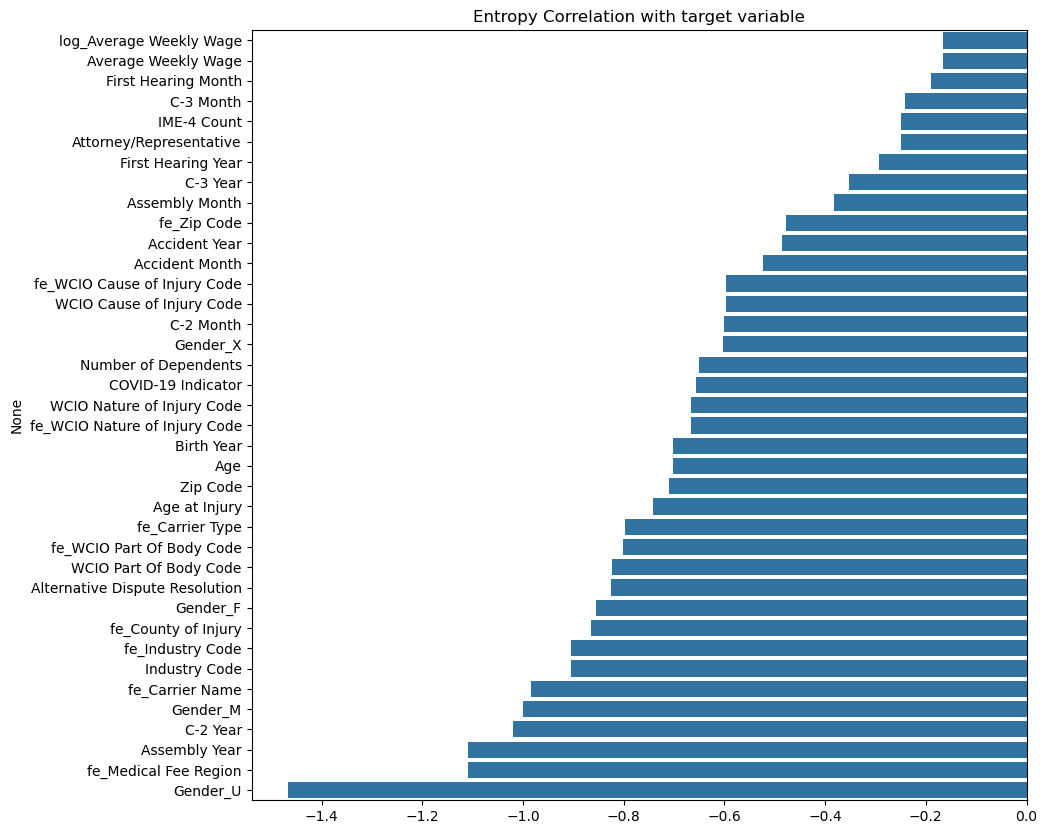

In [86]:
s_corr_y = []
for col in num_features:
    s_col = leo.two_col_entropy_corr(df_train[col], y_train)
    s_col = log((s_col +1)/2)
    s_corr_y.append(s_col)
    
s_corr_y = pd.Series(s_corr_y, index=num_features).sort_values(ascending=False)
s_corr_y = s_corr_y.sort_values(ascending=False)

plt.figure(figsize=(10, 10))
sns.barplot(x=s_corr_y.values, y=s_corr_y.index)
plt.title('Entropy Correlation with target variable')
plt.show()  

#### chi2 correlation for categorical features

In [87]:
from scipy.stats import chi2_contingency

Text(0.5, 0, 'x')

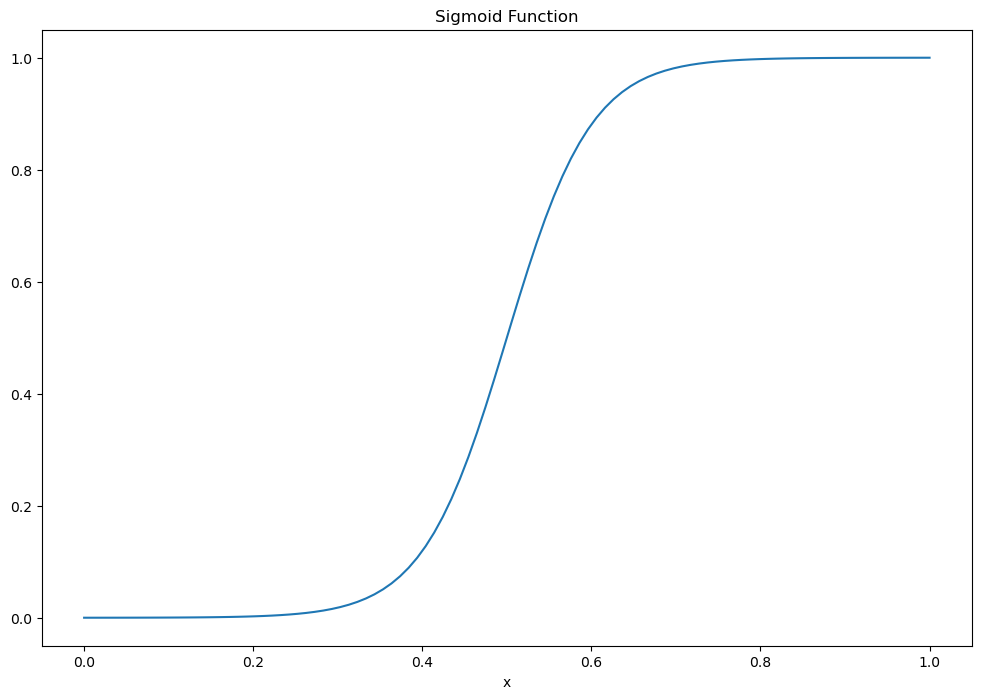

In [88]:
def sigmoid(x, a=20):
    return 1 / (1 + np.exp(-a * (x - 0.5)))

plt.figure(figsize=(12, 8))
x = np.linspace(0, 1, 100)
y = sigmoid(x)
plt.plot(x, y)
plt.title('Sigmoid Function')
plt.xlabel('x')

In [89]:
def chi2_feature_importance(f1, target, significance_level=0.05, log=False):
    """
    Evaluate if a feature is important to predict the target using the Chi-squared test.

    Parameters:
        data (pd.DataFrame): The dataset containing the feature and target.
        feature (str): The name of the feature column.
        target (str): The name of the target column.
        significance_level (float): The threshold for statistical significance (default 0.05).

    Returns:
        dict: A dictionary containing the chi-squared statistic, p-value, and whether the feature is important.
    """
    # Create a contingency table
    contingency_table = pd.crosstab(f1, target)

    # Perform the Chi-squared test
    chi2_stat, p_value, _, _ = chi2_contingency(contingency_table)

    total_observations = contingency_table.sum().sum()
    rows, cols = contingency_table.shape

    cramers_v = np.sqrt(
        chi2_stat / (total_observations * min(cols - 1, rows - 1)))

    is_important = p_value < significance_level

    if log:
        if cramers_v < 0.3:
            print(f" {is_important} the test is not significant {cramers_v}")
        elif cramers_v < 0.5:
            print(f" {is_important} the test is weakly significant {cramers_v}")
        elif cramers_v < 0.7:
            print(f" {is_important} the test is moderately significant {cramers_v}")
        elif cramers_v < 1:
            print(f" {is_important} the test is highly significant {cramers_v}")
        else:
            print(f"the test has no sense {cramers_v}")

    # Determine if the feature is important
    is_important = p_value < significance_level
    return cramers_v, p_value

In [90]:
df_train[col]

Claim Identifier
5877274   -0.319477
5482355   -0.314766
5654730   -0.231401
6029178   -0.321757
6108114    6.419561
             ...   
5875495   -0.306634
5598826   -0.295083
5550948   -0.304886
5979080   -0.046888
5803696    0.507789
Name: fe_Carrier Name, Length: 459220, dtype: float64

Feature: Carrier Name
 True the test is not significant 0.2888145719198827
normalized score: 0.01443287620431203
--------------------------------------------------
Feature: Carrier Type
 True the test is not significant 0.12979518239122967
normalized score: 0.0006083836200502684
--------------------------------------------------
Feature: County of Injury
 True the test is not significant 0.09502667718754158
normalized score: 0.0003036089263260645
--------------------------------------------------
Feature: District Name
 True the test is not significant 0.07067792185239427
normalized score: 0.00018658415927112897
--------------------------------------------------
Feature: Gender
 True the test is not significant 0.08164697773797797
normalized score: 0.00023234370026289035
--------------------------------------------------
Feature: Medical Fee Region
 True the test is not significant 0.0510406234720798
normalized score: 0.0001259893059784414
----------------------------------------------

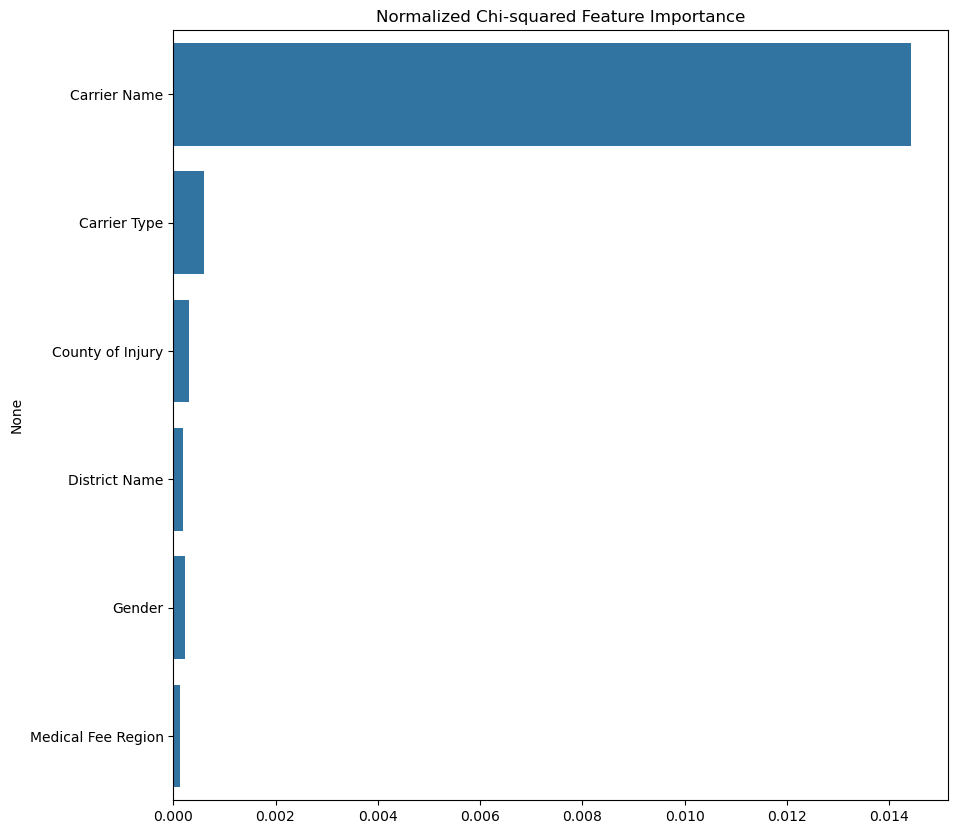

In [91]:
normalized_scores = []
 
for col in obj_features:
    print(f"Feature: {col}")
    cramers_v, p_value = chi2_feature_importance(df_train[col], y_train, log=True)
    normalized_scores.append((1 - p_value)*sigmoid(cramers_v))
    print(f'normalized score: {normalized_scores[-1]}')
    print("-"*50)

plt.figure(figsize=(10, 10))
sns.barplot(x=normalized_scores, y=obj_features)
plt.title('Normalized Chi-squared Feature Importance')
plt.show()

#### best features level 1

In [92]:
best_lin = list((corr_y [corr_y.abs() > 0.3]).index)
best_ent = list((s_corr_y [s_corr_y > - 0.4]).index)
best_chi2 = list((pd.Series(normalized_scores, index=obj_features)[pd.Series(normalized_scores, index=obj_features) > 0.5]).index)

In [93]:
bestnum = set(best_lin + best_ent)
bestnum = list(bestnum)
bestnum.append('fe_Carrier Name')
bestnum

['Assembly Month',
 'IME-4 Count',
 'Attorney/Representative',
 'Average Weekly Wage',
 'C-3 Month',
 'log_Average Weekly Wage',
 'First Hearing Year',
 'First Hearing Month',
 'C-3 Year',
 'fe_Carrier Name']

In [94]:
best_chi2

[]

### correlation between features

#### Linear correlation

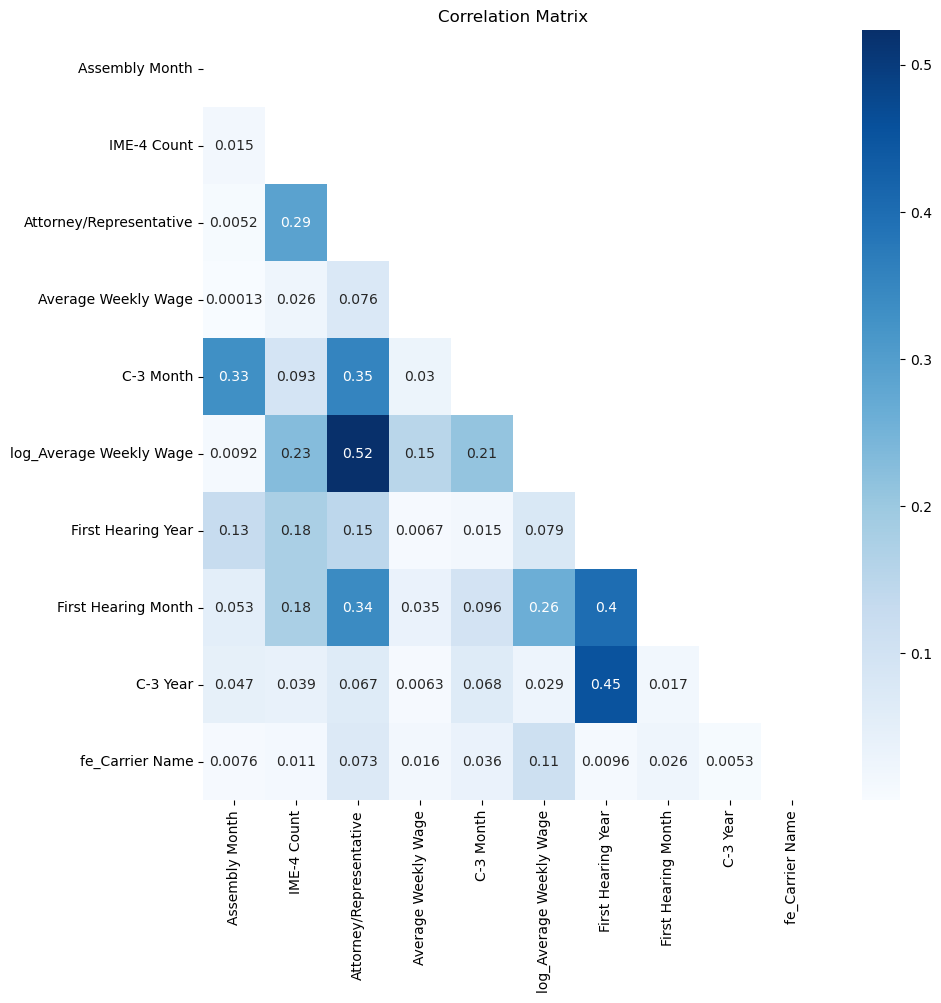

In [95]:
# correlation between numerical features
corr = df_train[bestnum].corr()
#half of the matrix
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(10, 10))
sns.heatmap(np.abs(corr), annot=True, cmap='Blues', mask=mask)
plt.title('Correlation Matrix')
plt.show()


#### entropy correlation

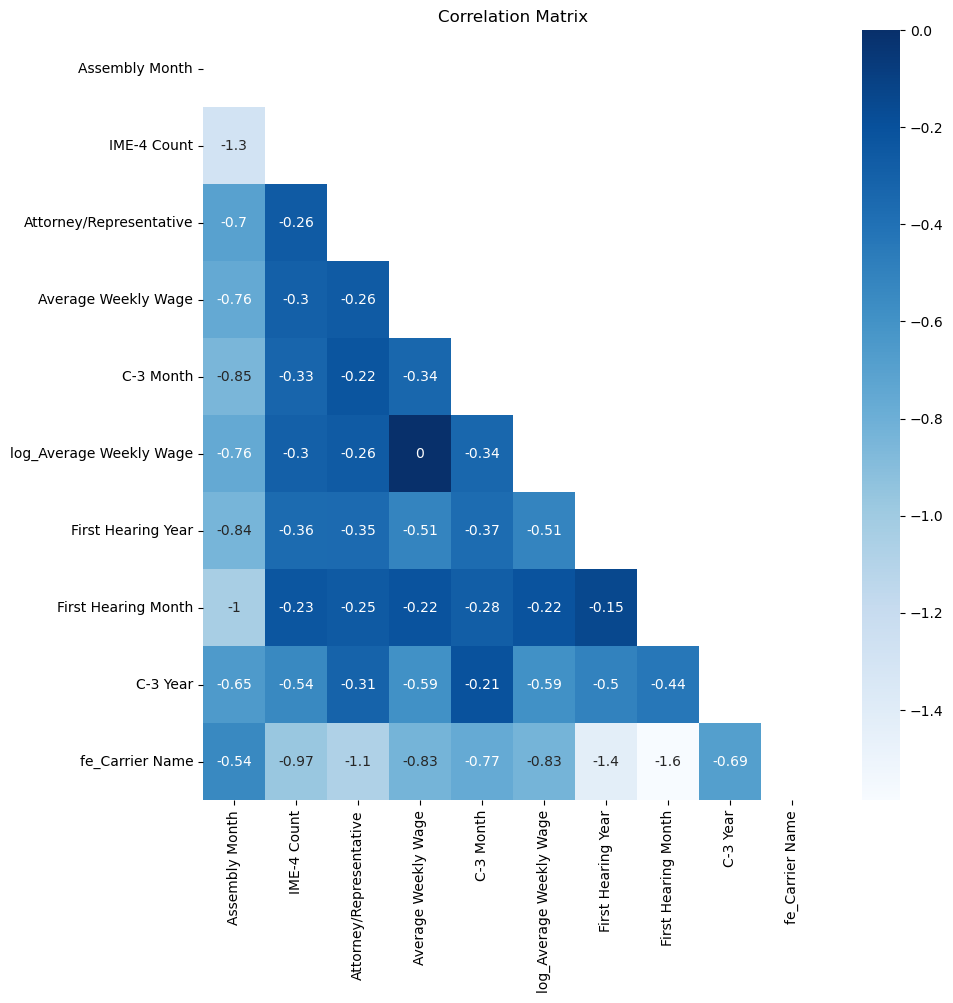

In [96]:
s_corr = leo.entropy_corr(df_train[bestnum])
#half of the matrix
mask = np.zeros_like(s_corr)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(10, 10))
sns.heatmap(s_corr, annot=True, cmap='Blues', mask=mask)
plt.title('Correlation Matrix')
plt.show()

#### best featues level 2


In [97]:
bestnum = ['IME-4 Count',
 'Attorney/Representative',
 'Average Weekly Wage',
 'fe_Zip Code',
 'First Hearing Year',
 'First Hearing Month',
 'fe_Carrier Name']

In [98]:
df_train['Carrier Name'].value_counts()

Carrier Name
STATE INSURANCE FUND              88951
POLICE, FIRE, SANITATION          17315
AMERICAN ZURICH INSURANCE CO      13978
CHARTER OAK FIRE INS CO           13887
INDEMNITY INS. OF N AMERICA       11469
                                  ...  
MARKEL AMERICAN INSURANCE COMP        1
FABIUS-POMPY CENTRAL                  1
JASPER-TROUPSBURG CSD                 1
SACKETTS HARBOR CENTRAL               1
KIRYAS JOEL VILLAGE UNION             1
Name: count, Length: 2001, dtype: Int64

# checkpoint 2

In [ ]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from imblearn.combine import SMOTETomek
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
import lightgbm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix


## smote and tomek

In [99]:
df_train_np = df_train[bestnum].to_numpy()
y_train_np = y_train.to_numpy(dtype=int)

In [100]:

smote_tomek = SMOTETomek(sampling_strategy='auto')

# Ensure y_train contains integer values
y_train_int = y_train.round().astype('float64').to_numpy()
# Assuming you have your feature matrix X and target variable y
X_train_resampled, y_train_resampled = smote_tomek.fit_resample(df_train_np, y_train_np)
df_train_resampled = pd.DataFrame(X_train_resampled, columns=bestnum)
y_train_resampled = pd.Series(y_train_resampled)

#smote = SMOTE(sampling_strategy='minority', random_state=42)

print("Resampling completed successfully!")

Resampling completed successfully!


In [101]:
y_train_resampled.value_counts()

1    227080
0    227080
Name: count, dtype: int64

## multiple model training

In [ ]:
# make grid search validation for every model in the list model_list_num
model_list_num = [LogisticRegression(), DecisionTreeClassifier(), RandomForestClassifier(), HistGradientBoostingClassifier()]

X_train_resampled_small, X_train_resampled_big, y_train_resampled_small, y_train_resampled_big = train_test_split(X_train_resampled, y_train_resampled, test_size=0.8, random_state=42,stratify=y_train_resampled)

param_grid_logistc = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

param_grid_tree = {
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 5, 10]
}

param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 5, 10]
}

param_grid_hgb = {
    'max_iter': [100, 200, 300],
    'max_depth': [5, 10, 15, 20],
    'min_samples_leaf': [2, 5, 10]
}

param_list = [param_grid_hgb,param_grid_logistc, param_grid_tree, param_grid_rf]
model_list_num = [ HistGradientBoostingClassifier(), LogisticRegression(), DecisionTreeClassifier(), RandomForestClassifier()]
model_names = ['HistGradientBoostingClassifier', 'LogisticRegression', 'DecisionTreeClassifier', 'RandomForestClassifier']
best_params = []

for model, param_grid in zip(model_list_num, param_list):
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1', n_jobs=-1)
    grid_search.fit(X_train_resampled_small, y_train_resampled_small)
    best_params.append(grid_search.best_params_)
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best score: {grid_search.best_score_}")



Best parameters: {'max_depth': 10, 'max_iter': 300, 'min_samples_leaf': 10}
Best score: 0.9049643692189576


/opt/anaconda3/envs/ML_env/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/envs/ML_env/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/envs/ML_env/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/envs/ML_env/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/envs/ML_env/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/anaconda3/envs/ML_env/lib/python3.12/site-packages/sklearn/svm/_base.p

Best parameters: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
Best score: 0.8949490604957904
Best parameters: {'max_depth': 10, 'min_samples_split': 10}
Best score: 0.9023482062817079
Best parameters: {'max_depth': 15, 'min_samples_split': 10, 'n_estimators': 100}
Best score: 0.9050057140710489


In [110]:
num_features_to_run = bestnum

tn_list = []
fp_list = []
fn_list = []
tp_list = []

for model, param in zip (model_list_num, best_params):
    model.set_params(**param)
    model.fit(X_train_resampled, y_train_resampled)
    y_pred = model.predict(df_valid[bestnum])
    print(f"Model: {model}")
    print(f"Accuracy: \n{accuracy_score(y_valid, y_pred)}")
    print(f"Precision: \n{precision_score(y_valid, y_pred)}")
    print(f"Recall: \n{recall_score(y_valid, y_pred)}")
    print(f"F1: \n{f1_score(y_valid, y_pred)}")
    print(f"ROC AUC: \n{roc_auc_score(y_valid, y_pred)}")
    print(f"Confusion Matrix: \n{confusion_matrix(y_valid, y_pred)}")
    print("-"*50)
    cm = confusion_matrix(y_valid, y_pred, normalize='pred')
    tn, fp, fn, tp = cm.ravel()
    tn_list.append(tn)
    fp_list.append(fp)
    fn_list.append(fn)
    tp_list.append(tp)
    


Model: HistGradientBoostingClassifier(max_depth=10, max_iter=300, min_samples_leaf=10)
Accuracy: 
0.8870964932146403
Precision: 
0.8576195242861909
Recall: 
0.9309898752953758
F1: 
0.8927998412094547
ROC AUC: 
0.8866531491242229
Confusion Matrix: 
[[47868  8961]
 [ 4001 53976]]
--------------------------------------------------
Model: LogisticRegression(C=1, penalty='l1', solver='liblinear')
Accuracy: 
0.8814173475253907
Precision: 
0.827088402270884
Recall: 
0.9674353622988426
F1: 
0.8917737216993131
ROC AUC: 
0.8805485245568365
Confusion Matrix: 
[[45103 11726]
 [ 1888 56089]]
--------------------------------------------------
Model: DecisionTreeClassifier(max_depth=10, min_samples_split=10)
Accuracy: 
0.8357141612807693
Precision: 
0.8647791703968964
Recall: 
0.7997309277817065
F1: 
0.8309840222953052
ROC AUC: 
0.8360776090984057
Confusion Matrix: 
[[49579  7250]
 [11611 46366]]
--------------------------------------------------
Model: RandomForestClassifier(max_depth=15, min_sample

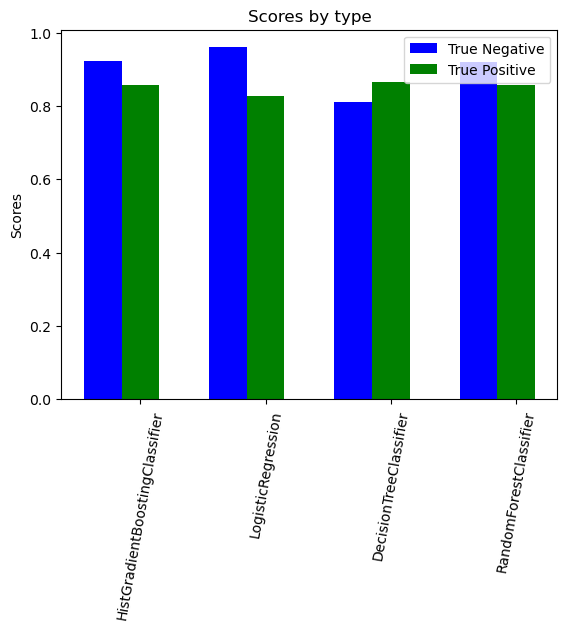

In [111]:
model_names = ['HistGradientBoostingClassifier', 'LogisticRegression', 'DecisionTreeClassifier', 'RandomForestClassifier']

fig, ax = plt.subplots()
width = 0.3 # width of bar
x = np.arange(len(model_names))
ax.bar(x, tn_list, width, color='b', label='True Negative')
ax.bar(x + width, tp_list, width, color='g', label='True Positive')
# rotate the tick labels for better visibility
ax.set_xticklabels(model_names, rotation = 80)
ax.set_ylabel('Scores')
ax.set_title('Scores by type')

ax.set_xticks(x + width)
ax.set_xticklabels(model_names)
ax.legend()
plt.show()

In [ ]:
y_train_resampled_4_xgb = y_train_resampled - 1
y_valid_4_xgb = y_valid - 1


dtrain = xgb.DMatrix(df_train_resampled, label=y_train_resampled_4_xgb)
dvalid = xgb.DMatrix(df_valid[num_features_to_run], label=y_valid_4_xgb)

# run a grid search for param_xgb
param_xgb = {
    'max_depth': [3, 5, 7],
    'eta': [0.1, 0.3, 0.5],
    'objective': ['multi:softprob'],
    'num_class': [2]
}

grid = GridSearchCV(estimator=xgb.XGBClassifier(), param_grid=param_xgb, cv=5, n_jobs=-1)
grid.fit(df_train_resampled, y_train_resampled_4_xgb)
print(grid.best_params_)


param = {
    'max_depth': 3,  # the maximum depth of each tree
    'eta': 0.3,  # the training step for each iteration
    'objective': 'multi:softprob',  # error evaluation for multiclass training
    'num_class': 2}  # the number of classes that exist in this datset
num_round = 20  # the number of training iterations

# checkpoint 3

## recursive feature elimination

In [ ]:
# import RFE
from sklearn.feature_selection import RFE
# import SelectKBest
from sklearn.feature_selection import SelectKBest,chi2, f_classif
# import SelectFromModel
from sklearn.feature_selection import SelectFromModel
features_to_RFE = num_features

X_small, X_big, y_small, y_big = train_test_split(df_train[features_to_RFE], y_train, test_size=0.2, random_state=0)
# create a base classifier used to evaluate a subset of attributes
model = RandomForestClassifier()
scores = np.zeros(len(features_to_RFE))
for numb_of_features in range( 3, len(features_to_RFE)):
    rfe_selector = RFE(estimator=model, n_features_to_select=numb_of_features)
    rfe_selector = rfe_selector.fit(X_small[features_to_RFE], y_small)
    print(f"Num Features: {rfe_selector.n_features_}")
    print(f"Selected Features: {np.array(features_to_RFE)[rfe_selector.support_]}")
    print(f"Feature Ranking: {rfe_selector.ranking_}")
    print("-"*50)
    scores[numb_of_features] = rfe_selector.score(X_big[features_to_RFE], y_big)
    
plt.plot(scores)
plt.title('RFE')
plt.show()


# checkpoint 4

## grid search for hyperparameters

In [ ]:
# grid search fro best hyperparameters
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score


# Create the parameter grid based on the results of random search
param_grid_logistc = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

param_grid_random_forest = {
    'n_estimators': [100, 200, 300, 1000],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

param_grid_decision_tree = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [4,5,6,7,8,9,10]
}


In [ ]:
# grid search for logistic regression

grid_search = GridSearchCV(estimator = LogisticRegression(), param_grid = param_grid_logistc,
                cv = 3, n_jobs = -1, verbose = 2)   